# About the data

Features Explanation:
* distancefromhome, numeric - the distance from home where the transaction happened.
* distancefromlast_transaction, numeric - the distance from last transaction happened.
* ratiotomedianpurchaseprice, numeric - Ratio of purchased price transaction to median purchase price.
* repeat_retailer, binary - Is the transaction happened from same retailer.
* used_chip, binary - Is the transaction through chip (credit card).
* used_pin_number, binary - Is the transaction happened by using PIN number.
* online_order, binary - Is the transaction an online order.
* fraud, binary - Is the transaction fraudulent.

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

data_path = 'card_transdata.csv'
data = pd.read_csv(data_path)
data = data.drop(columns=["distance_from_last_transaction"]) # MM, not intended later for serving exercise
n = data.shape[0]
data.head()

,distance_from_home,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,2.222767,1.0,1.0,0.0,1.0,0.0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   ratio_to_median_purchase_price  1000000 non-null  float64
 2   repeat_retailer                 1000000 non-null  float64
 3   used_chip                       1000000 non-null  float64
 4   used_pin_number                 1000000 non-null  float64
 5   online_order                    1000000 non-null  float64
 6   fraud                           1000000 non-null  float64
dtypes: float64(7)
memory usage: 53.4 MB


In [31]:
data.describe()

,distance_from_home,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


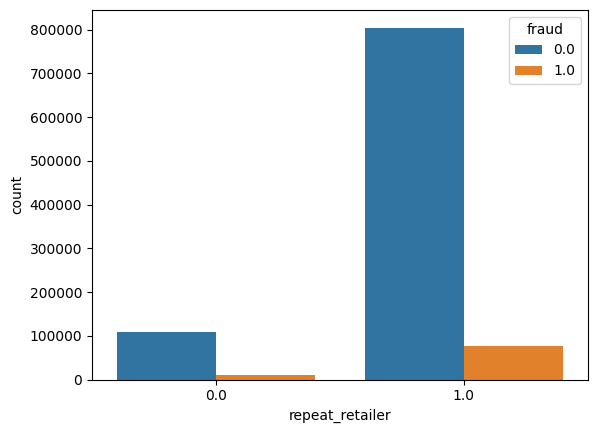

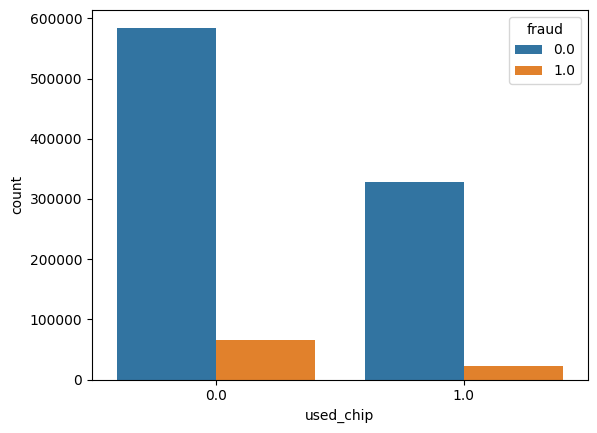

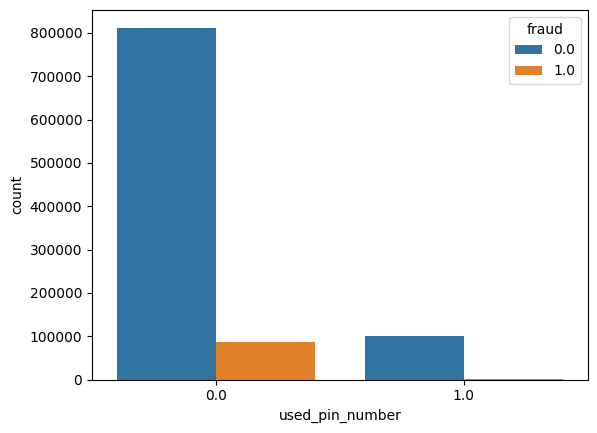

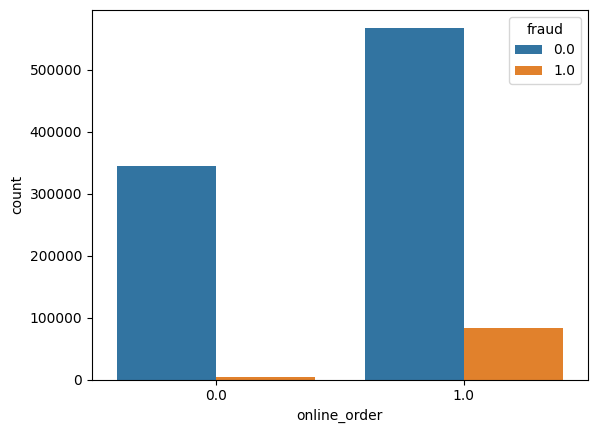

In [32]:
# Data distribution
for col in ['repeat_retailer','used_chip','used_pin_number','online_order']:
    sns.countplot(data=data,x=col,hue='fraud')
    plt.show()

In [33]:
# Unbalanced data
print('Percentage of fraud in whole dataset:', 100*data.loc[data.fraud==1].shape[0]/n)

Percentage of fraud in whole dataset: 8.7403


Notes from barplots:
* transaction happened with PIN number are not subject to fraud
* most of the fraud have been done over online orders

In [34]:
print('Percentage of fraud not using PIN:',
      100*data.loc[(data.fraud==1) & (data.used_pin_number==0)].shape[0]/data.loc[data.fraud==1].shape[0])
print('Percentage of fraud in online orders:',
      100*data.loc[(data.fraud==1) & (data.online_order==1)].shape[0]/data.loc[data.fraud==1].shape[0])

Percentage of fraud not using PIN: 99.6876537418624
Percentage of fraud in online orders: 94.63176321178906


Since target data are unbalanced we will set as our baseline an unsophisticated  model that marks fraudolent every online transaction as it makes much more sense than considering wether the transaction occurred using PIN, even though it seem to have a higher impact on the target with these data.

<Axes: >

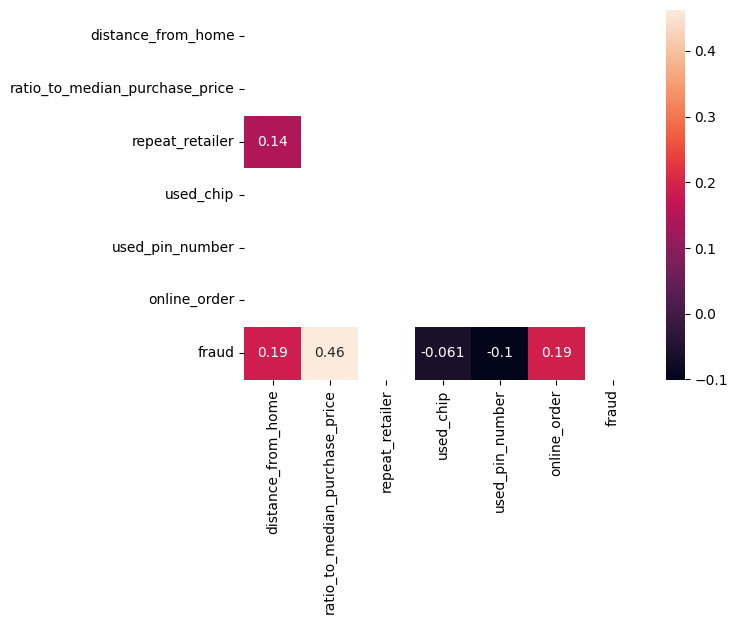

In [35]:
# correlation heatmap
corr = data.corr()
sns.heatmap(data=corr, annot=True, mask=np.triu(corr)|(np.abs(corr)<0.01))

# Preprocessing and Hyperparameter Tuning

In [36]:
# Preprocessing and Splitting
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

X_sc = data.copy()
features_names = data.columns.tolist()
features_names.remove('fraud')
MMsc = MinMaxScaler()
X_sc[features_names] = MMsc.fit_transform(data[features_names])

scale_ = MMsc.scale_  # array of per-feature scale values
min_ = MMsc.min_  # array of per-feature min values
np.savetxt('scale_values.txt', scale_)
np.savetxt('min_values.txt', min_)

y_sc = X_sc.pop('fraud')
X_train, X_test, y_train, y_test = train_test_split(X_sc,y_sc, test_size=0.2, shuffle=False) ## MM no shuffle

In [37]:
# Random Forest Classifier Tuning (Commented to run faster)
# from sklearn.model_selection import GridSearchCV
# n_estimators_range = range(3,8)
# max_depth_range = range(3,13,3)
# param_grid ={'n_estimators': n_estimators_range, 'max_depth': max_depth_range,
#              'random_state': [5]}

# start_time = time.time()

# rfc_grid = GridSearchCV(estimator=RandomForestClassifier(),
#              param_grid=param_grid, scoring='accuracy',)
# rfc_grid.fit(X_train,y_train)

# elapsed_time = time.time()-start_time

# print('RFC tuning time: ', elapsed_time)
# print('Best score obtained with RFC: '+str(rfc_grid.best_score_))
# print('by setting',rfc_grid.best_params_)

# results = rfc_grid.cv_results_
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# x = results['param_max_depth']
# y = results['param_n_estimators']
# z = results['mean_test_score']
# ax.scatter(x, y, z)
# ax.set_xlabel('max_depth')
# ax.set_ylabel('n_estimators')
# ax.set_zlabel('mean_test_score')

# Model Evaluation and Features Importances

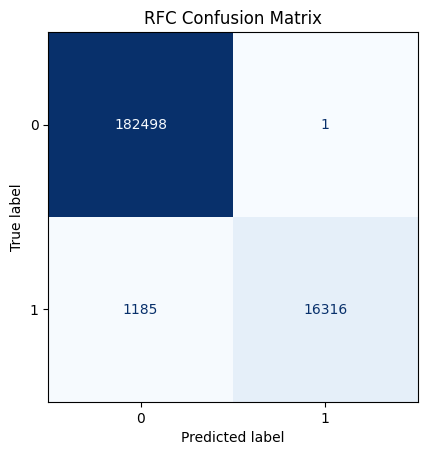

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.993549,0.999939,0.99407,0.996744,0.994108
recall,0.999995,0.932290,0.99407,0.966142,0.994070
f1-score,0.996761,0.964930,0.99407,0.980846,0.993976
support,182499.000000,17501.000000,0.99407,200000.000000,200000.000000


In [38]:
#Run RFC and evaluate model on test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

rfc = RandomForestClassifier(n_estimators=5, max_depth=12, random_state=5)
rfc.fit(X_train,y_train)
y_rfc = rfc.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_rfc)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', colorbar=False)
plt.title('RFC Confusion Matrix')
plt.show()

report = pd.DataFrame(data=classification_report(
    y_true=y_test, y_pred=y_rfc, output_dict=True))
report

Now that we have built our model and ensured it has an almost perfect prediction power we focus on the interpretability of our model. We will look at features importances in the RandomForestClassifier used for classification and then look at how the base estimator in the forest combined them in order to get to its results (we suggest to download the decision path to take a closer look).

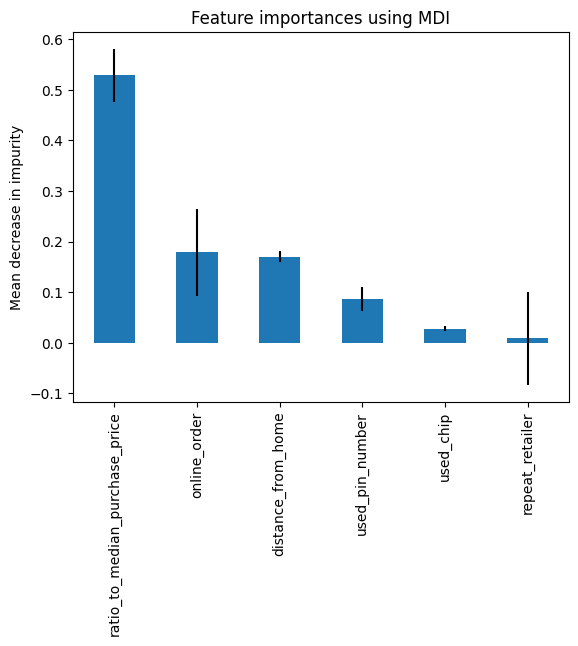

Mean features importance
ratio_to_median_purchase_price: 0.5289826342702987
online_order: 0.17842647990492344
distance_from_home: 0.17012745121696854
used_pin_number: 0.08568642960124649
used_chip: 0.028127759937730888
repeat_retailer: 0.008649245068831914


In [39]:
#Feature importances
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
rfc_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
rfc_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Minimum decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
plt.show()

print('Mean features importance')
for feature in rfc_importances.index:
    print(feature+': '+str(rfc_importances[feature]))

In [40]:
data[data["fraud"] == 1]

,distance_from_home,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
13,2.131956,6.358667,1.0,0.0,0.0,1.0,1.0
24,3.803057,1.872950,1.0,0.0,0.0,1.0,1.0
29,15.694986,0.855623,1.0,0.0,0.0,1.0,1.0
35,26.711462,4.603601,1.0,1.0,0.0,1.0,1.0
36,10.664474,4.886521,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
999908,45.296658,8.856861,1.0,0.0,0.0,1.0,1.0
999916,167.139756,0.308468,1.0,0.0,0.0,1.0,1.0
999919,124.640118,0.434885,1.0,0.0,0.0,1.0,1.0
999939,51.412900,29.914254,1.0,0.0,0.0,1.0,1.0


In [41]:
from joblib import dump
dump(rfc, 'model.joblib')

['model.joblib']

In [44]:
import json
def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

row = 13
print(data.iloc[row])
print(X_train.iloc[row])
print(y_train.iloc[row])
x = X_train.iloc[row].values.reshape(1, -1)
print(x)
print(json.dumps(x, default=default))
rfc.predict(x)

distance_from_home                2.131956
ratio_to_median_purchase_price    6.358667
repeat_retailer                   1.000000
used_chip                         0.000000
used_pin_number                   0.000000
online_order                      1.000000
fraud                             1.000000
Name: 13, dtype: float64
distance_from_home                0.000200
ratio_to_median_purchase_price    0.023728
repeat_retailer                   1.000000
used_chip                         0.000000
used_pin_number                   0.000000
online_order                      1.000000
Name: 13, dtype: float64
1.0
[[2.00050554e-04 2.37277918e-02 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
[[0.00020005055351907927, 0.023727791839971268, 1.0, 0.0, 0.0, 1.0]]


/Users/mmortari/git/demo20240608-KFcomponents/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1.])